In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection, cross_validation, preprocessing, ensemble, metrics, manifold
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import warnings
from sklearn.utils import shuffle
warnings.filterwarnings("ignore", category=DeprecationWarning) 
data = pd.read_csv('Train_full.csv', sep =',')

In [3]:
def labelEncoder(data):
    data = data.fillna(0)
    le = preprocessing.LabelEncoder()
    for m in range(190,230):
        le.fit(data.iloc[:,m])
        data.iloc[:,m] = le.transform(data.iloc[:,m])       
    return data
def dropUninformative(data):
    df = pd.DataFrame([])
    for i in range(data.shape[1]):
        if len(np.unique(data.iloc[:,i]))>1:
            df["Var"+str(i)] = data.iloc[:,i]
    return df

In [4]:
def undersampling(data, alpha):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    countChurn = len(dataChurn)
    countNoChurn = len(dataNoChurn)
    np.random.seed(42)
    rands = np.random.randint(0,countNoChurn, countChurn*alpha)
    dataChurn = dataChurn.append(dataNoChurn.iloc[rands,:])
    dataChurn = shuffle(dataChurn)
    return dataChurn.iloc[:,:212], dataChurn.iloc[:,212:]

In [5]:
def economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance):
    df_clients = pd.DataFrame([])
    df_clients['predict'] = predicted
    df_clients['y_true'] = y_true
    df_clients['profit'] = 0
    np.random.seed(27)
    rands = pd.DataFrame(data = np.random.random(len(predicted)), columns=['random'])
    df_clients.sort_values('predict', inplace = True, ascending=False)
    threshold = df_clients.iloc[int(len(df_clients)*top)-1, 0]
    profit = 0
    
    df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == 1)].index] = 0
    df_clients['profit'].loc[df_clients[(df_clients['predict']<threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1 
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']>randomChance)].index]= 0-costFor1
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == 1)][(rands['random']<randomChance)].index]= incomeFor1-costFor1 
    df_clients['profit'].loc[df_clients[(df_clients['predict']>threshold)][(df_clients['y_true'] == -1)].index] = incomeFor1-costFor1
    
    profit = sum(df_clients['profit'])
    
    statistic = stats(df_clients, top, profit, incomeFor1, costFor1, 0.2, randomChance)
    return profit, df_clients, statistic


In [6]:
def plot_income(y_true, predicted, incomeFor1, costFor1, randomChance):
    tops = np.linspace(0.005,1., num = 200)
    incomes = []
    statistic = pd.DataFrame([])
    for top in tops:
        incomes.append(economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance)[0])
        statistic=statistic.append(economic_model(y_true, predicted, top, incomeFor1, costFor1, randomChance)[2], ignore_index=True)
    plt.figure(figsize=(20,10))
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(tops, incomes, color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(tops[0], incomes[0], 'ro', label = u'соответствует значению без удержания клиентов')
    plt.plot(tops[-1], incomes[-1], 'bo', label = u'соответствует значению после опроса всех клиентов')
    df = pd.DataFrame([])
    df['Profit'] = incomes
    df['Top'] = tops
    plt.legend(loc="best")
    return df, statistic

In [7]:
def plot_stats(df):
    plt.figure(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(df.iloc[:,0], df.iloc[:,1], '--', color="r", label=u"прибыль с 20% оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,2], '--',color="k", label=u"прибыль с учетом обзвона всех клиентов")
    plt.plot(df.iloc[:,0], df.iloc[:,3],color="g", label=u"прибыль с учетом прогноза оттока")
    plt.plot(df.iloc[:,0], df.iloc[:,8],color="b", label=u"прибыль в будущем(после прогноза и затрат)")
    plt.title(u"график зависимости полученной прибыли от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.legend(loc="best")

In [8]:
def stats(df, top, profit, incomeFor1, costFor1, churn, chance):
    temp = pd.DataFrame([[top,
                        len(df)*(1-churn)*incomeFor1,
                        len(df)*1.*(incomeFor1-costFor1) - len(df)*churn*(incomeFor1)*(1-chance),
                        profit,
                        len(df),
                        int(len(df)*(1-churn)),
                        len(df[df['profit']>0]),
                        len(df)*incomeFor1*0.8,
                        len(df[df['profit']>0])*incomeFor1]],
                        columns=['top of predicted clients',
                                'profit without anything',
                                'profit with all called clients',
                                'profit with predicted clients',
                                'number of clients before predict',
                                'number of clients after no predict',
                                'number of clients after predict',
                                'profit in next time(no predict, next month with action)',
                                'profit in next time(predict, next month with action)'])
    return temp

In [9]:
import copy
def plot_year_prediction(stats, stats2, increase_percent, predict, costFor1, chance1, income):
    
    columns=['top of predicted clients',
            'increase clients (no predict)',
            'increase clients (predict)',
            'increase clients (all called)',
            'profit (year, no predict)',
            'profit (year, predict)',
            'profit (year, all called)']
    df = pd.DataFrame(columns = columns)
    increase_plan = (1.+increase_percent)*len(predict)
    print increase_plan
    for i in range(len(stats)):
        sample = [
            stats.iloc[i,0],
            increase_plan - stats.iloc[i,5],
            increase_plan - stats.iloc[i,6],
            increase_plan - stats.iloc[i,4],
            stats.iloc[i,1],
            stats.iloc[i,3],
            stats.iloc[i,2]
        ]
        
        first_month = copy.copy(sample)
        second_month = [
            stats.iloc[i,0],
            increase_plan - stats2.iloc[i,5],
            increase_plan - stats2.iloc[i,6],
            increase_plan - stats2.iloc[i,4],
            stats2.iloc[i,1],
            stats2.iloc[i,3],
            stats2.iloc[i,2]
        ]
        sample[4] += (first_month[4] - (((sample[1]/chance1)*costFor1)/12) + (((sample[1]*income)*(1))/12))
        sample[5] += (first_month[5] - (((sample[2]/chance1)*costFor1)/12) + (((sample[2]*income)*(1))/12))
        sample[6] += (first_month[6] - (((sample[3]/chance1)*costFor1)/12) + (((sample[3]*income)*(1))/12))
        for month in range(10):
            sample[4] += (second_month[4] - (((sample[1]/chance1)*costFor1)/12) + (((sample[1]*income)*(month+2))/12))
            sample[5] += (second_month[5] - (((sample[2]/chance1)*costFor1)/12) + (((sample[2]*income)*(month+2))/12))
            sample[6] += (second_month[6] - (((sample[3]/chance1)*costFor1)/12) + (((sample[3]*income)*(month+2))/12))
        temp_df = pd.DataFrame(data = [sample], columns=columns)
        df = df.append(temp_df)
        
    plt.figure(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Top")
    plt.ylabel("Profit")
    plt.plot(df.iloc[:,0], df.iloc[:,4],color="r", label=u'profit (year, no predict)')
    plt.plot(df.iloc[:,0], df.iloc[:,5],color="g", label=u'profit (year, predict)')
    plt.plot(df.iloc[:,0], df.iloc[:,6],color="b", label=u'profit (year, all called)')
    plt.title(u"график зависимости полученной прибыли за год от топа прогнозируемых клиентов после проведения кампании по удержанию")
    plt.legend(loc="best")
    return df

# 1. Постановка задачи:
* (данные взяты у одной известной белорусской телекоммуникационной компании :))
### в 2016-2017 годах была проведена акция: при подключении нового абонента действует скидка в 50% от полной стоимости тарифного плана в течение года. Будем прогнозировать пользователей, склонных к оттоку после окончания действия скидки.
### исходные данные:
        1. Процент конверсии пользователей - 20%;
        2. цена тарифного плана после окончания скидки 31р;
        3. расходы предприятия на контакт с пользователем + затраты на работу сотрудников 1.3р на одного абонента;
        4. предлагаем 20% скидку пользователям, склонных к оттоку;
        5. процент согласившихся пользователей, после мероприятий по удержанию 60%.
        

* для нужного нам процента конверсии обрезаем тестовую выборку в соотношении 1:4(отток/не отток)
* расходы считались как сумма скидки для удерживаемого пользователя + затрата на звонок
* в среднем у работника уходит 15 минут на разговор с клиентом, зарплата у сотрудника 1000р. т.е. затрата на звонок = зарплата/рабочие_дни/рабочие_часы/минуты*время_звонка -> 1.3р
* давать прошлогоднюю скидку старому клиенту невыгодно, поэтому даем меньшую (20%)
* random_seed везде зафиксирован для повторяемости результатов

In [10]:
# подготавливаем выборку
x_data = data.iloc[:,:230]
y_data = data.iloc[:,230:]
x_data = labelEncoder(x_data)
x_data = dropUninformative(x_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.25, random_state = 28)

x_test['labels'] = y_test
x_test, y_test = undersampling(x_test, alpha=4)
x_test.shape

C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(3770, 212)

In [11]:
print float(pd.value_counts(y_train['labels'])[-1])/len(y_train)
print float(pd.value_counts(y_train['labels'])[1])/len(y_train)
print float(pd.value_counts(y_test['labels'])[-1])/len(y_test)
print float(pd.value_counts(y_test['labels'])[1])/len(y_test)

0.925933333333
0.0740666666667
0.8
0.2


In [12]:
# обучаем модель с раннее найденными параметрами
gbm = lgb.LGBMClassifier(colsample_bytree= 1.0,
                            max_depth= 2,
                            min_child_weight= 1,
                            n_estimators= 170,
                            reg_alpha= 0.4,
                            reg_lambda= 1.0,
                            subsample= 1.0)
gbm.fit(x_train, y_train)


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\sklearn\preprocessing\label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=2, min_child_samples=20,
        min_child_weight=1, min_split_gain=0.0, n_estimators=170,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.4, reg_lambda=1.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 


C:\ProgramData\Anaconda3\envs\py27\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


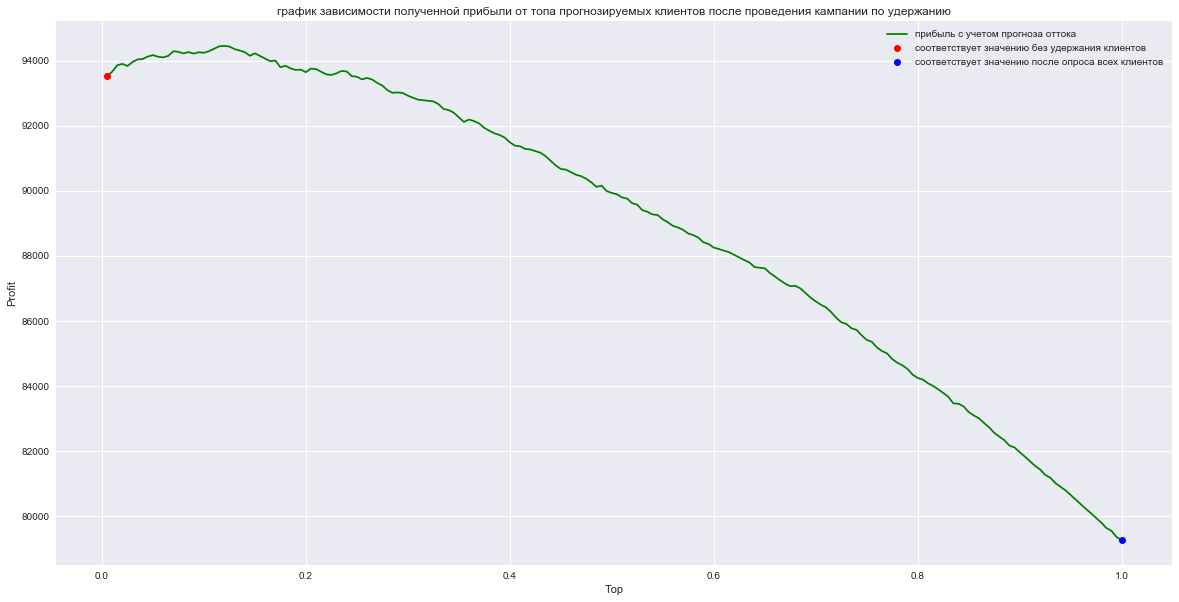

In [14]:
predicted = gbm.predict_proba(x_test.iloc[:,:212])[:,1]
incomeFor1 = 31.
costFor1 = 1.3 + 0.20*incomeFor1
randomChance = 0.60
statistic = plot_income(y_test.values, predicted, incomeFor1, costFor1, randomChance)[1]


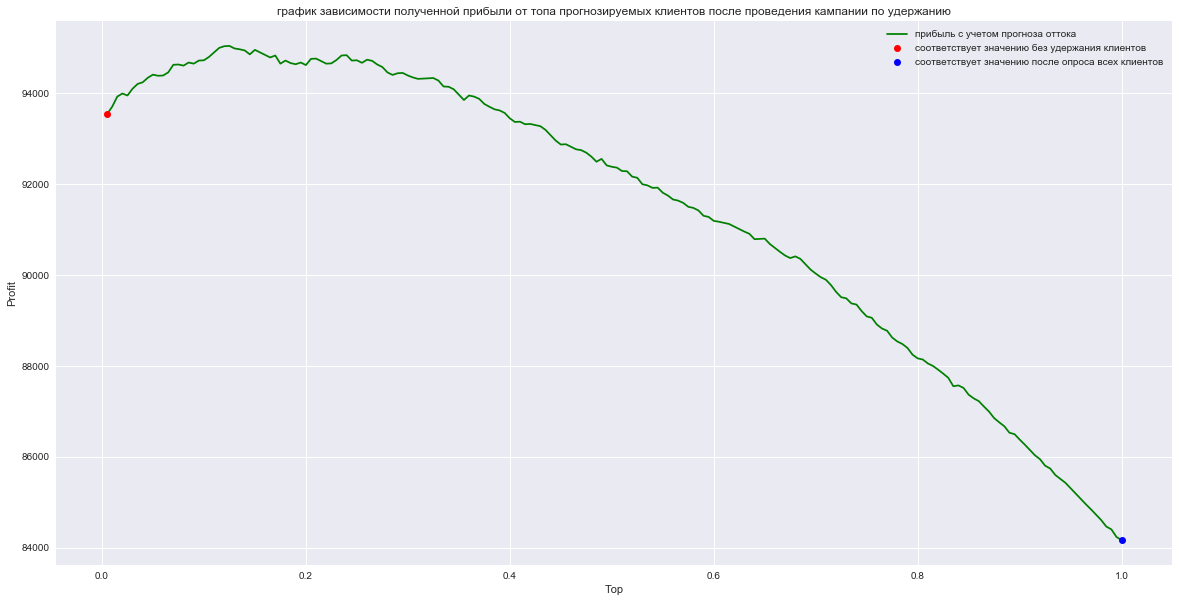

In [15]:
# понадобится в будущем
statistic_second_month = plot_income(y_test.values, predicted, incomeFor1, costFor1-1.3, randomChance)[1]

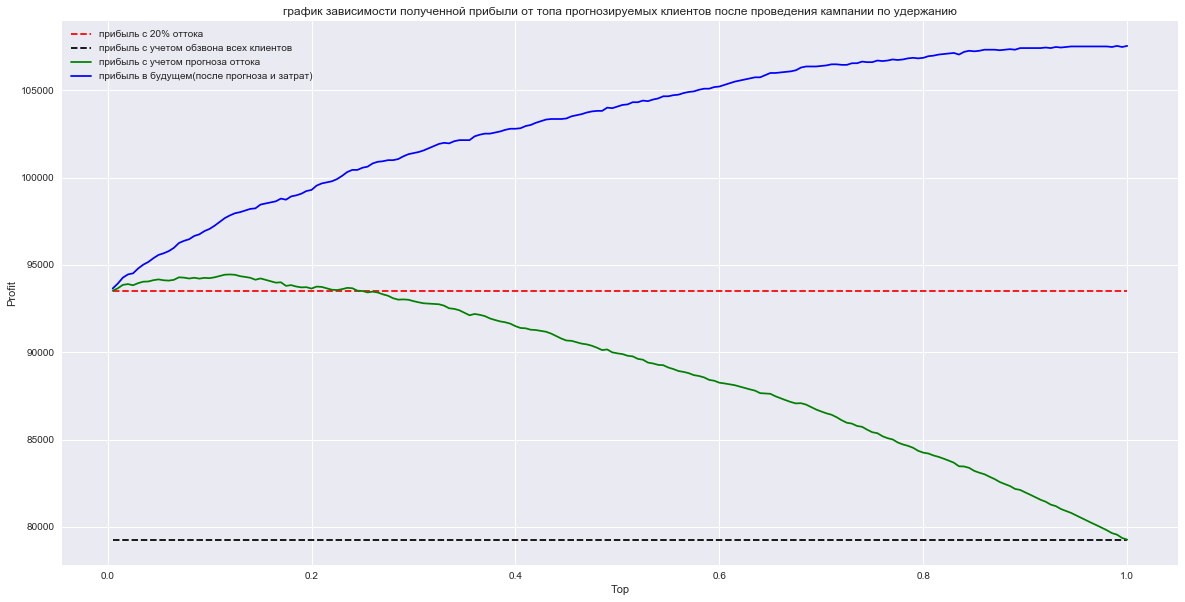

In [16]:
plot_stats(statistic)

## 2. Размер оптимального топа 10-12% (видно на графиках выше). При таких значениях экономический эффект наибольший

## 3. Усложним модель, попробуем посчитаем прибыль на год вперед после проведения кампании по удержанию.
    1. известно, что компания должна нарастить базу на 10% от начального количества абонентов. Для этого компании нужно добрать абонентов до прошлогоднего уровня после кампании по удержанию и добавить 10%
    2. шанс, с которым новый абонент согласится на услугу - 50%
    3. Затраты на нового абонента - 1.3р
    4. всем новым абонентам предлагаем скидку в 50%(15,5р)
* для подсчета необходимо просчитать прибыль за первый месяц после проведения кампании по удержанию. Далее мы просчитываем прибыль за следующие месяцы. За каждый месяц равными долями проводится кампания по привлечению новых клиентов.

4147.0


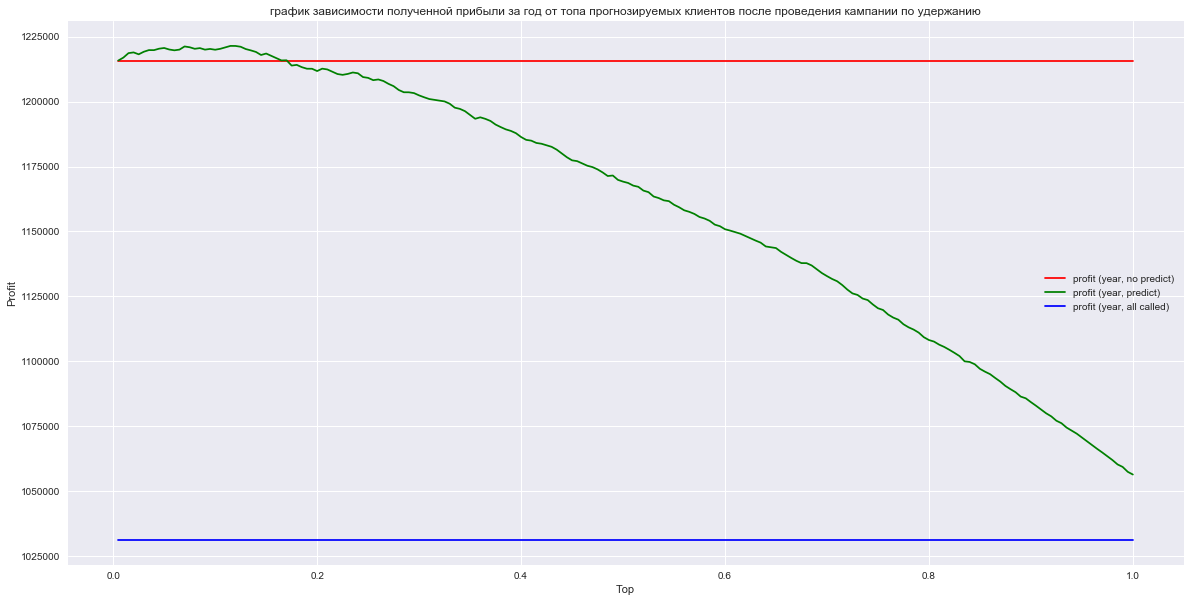

In [17]:
profit_year = plot_year_prediction(statistic,statistic_second_month, 0.1, predicted, 1.3, 0.5, 15.5)

In [18]:
print 'максимальная годовая прибыль после проведения единоразовой кампании по удержанию клиентов: '+ str(max(profit_year.iloc[:,4]))
print 'максимальная годовая прибыль без проведения единоразовой кампании по удержанию клиентов: '+ str(max(profit_year.iloc[:,5]))
print 'максимальная годовая прибыль после предложения удержания всех клиентов: '+ str(max(profit_year.iloc[:,6]))

максимальная годовая прибыль после проведения единоразовой кампании по удержанию клиентов: 1215674.2
максимальная годовая прибыль без проведения единоразовой кампании по удержанию клиентов: 1221443.2
максимальная годовая прибыль после предложения удержания всех клиентов: 1031195.53333


### 4. Применение экономической модели становится неоправданным в том случае, когда затраты на удержание становятся слишком большими, например:

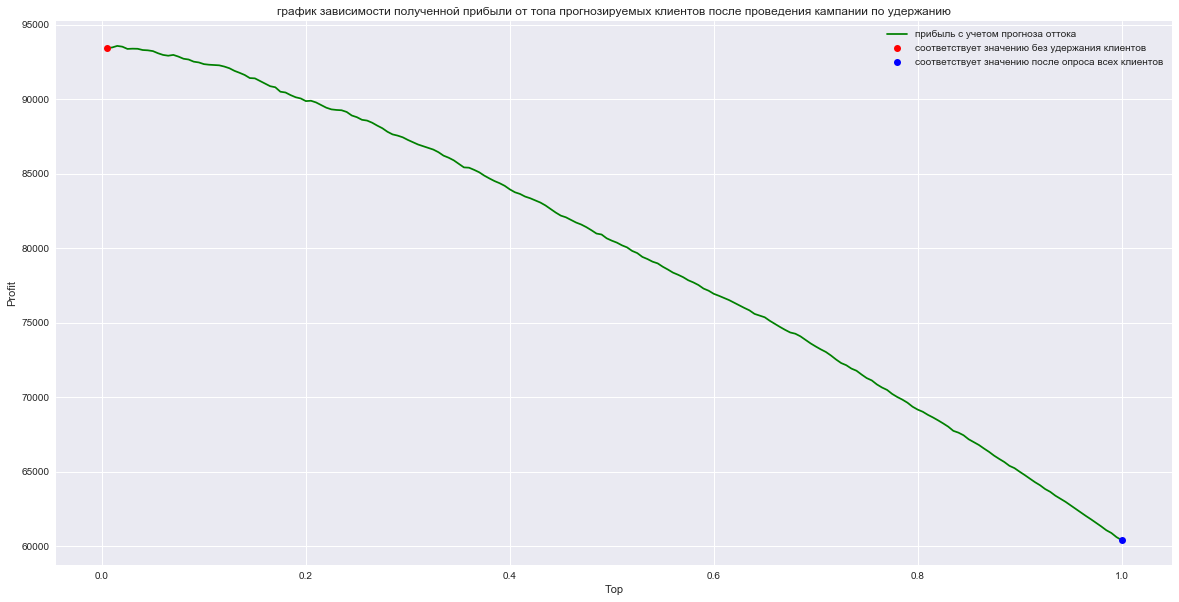

In [19]:
# увеличим затраты на связь с клиентом
incomeFor1 = 31.
costFor1 = 1.3 + 0.20*incomeFor1 + 5
randomChance = 0.60
statistic = plot_income(y_test.values, predicted, incomeFor1, costFor1, randomChance)[1]


### 5. при увеличении качества модели на 1-3% экономический эффект будет небольшим или вовсе не будет, так как качество оценивалось по метрике AUC ROC. Для этой метрики увеличение качества может значить, что уверенность алгоритма в правильно классифицируемых объектах стала болше, а количество ошибок первого/второго рода осталось таким же, следовательно экономического эффекта может не быть вовсе. Для увеличения экономического эффекта нужно работать над уменьшением количества ошибок первого/второго рода.

### 6. Вложение средств может быть оправданным только в том случае, когда модель будет давать меньше ошибок первого/второго рода. Нужно оценить прибыль от увеличения качества классификации и затраты на увеличение качества модели, только тогда можно судить о вложении средств в увеличение качества модели.